기계 학습을 이용한 감정 상태 분석

In [2]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

 데이터 불러오기
   - train data - https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
   - test data - https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
   - 받아온 데이터를 dataframe으로 변환하고 데이터를 확인

In [3]:
# Data load

train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


중복 및 결측치 처리

In [4]:
print(train_data['document'].nunique())
print(train_data['label'].nunique())

# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

146182
2


In [5]:
# 결측치 확인
print(train_data.isnull().sum())

train_data = train_data.dropna(how='any')

id          0
document    1
label       0
dtype: int64


데이터 정제
   - 데이터에서 한글과 공백을 제외하고 모두 제거

In [6]:
# 정규화
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

train_data

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [7]:
# 공백의 리뷰들 검색
train_data['document'].replace('', np.nan, inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

# 공백의 리뷰들 제거
train_data = train_data.dropna(how='any')
print(len(train_data))

146182
id            0
document    391
label         0
dtype: int64
145791


In [8]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


토큰화 및 불용어 사전
   - 불용어 사전 : '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'

In [9]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [10]:
mecab = Mecab('C:/mecab/mecab-ko-dic')

# for train
x_train = []
for sentence in train_data['document']:
    x_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

# for test
x_test = []
for sentence in test_data['document']:
    x_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

빈도 수가 낮은 단어 제거

In [12]:
threshold = 3
word_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0 
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    word_freq = words_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value
print("전체 단어 수 : ", word_cnt)
print("빈도가 {} 이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율 : {}".format((rare_cnt / word_cnt)*100))
# print("희귀 단어 등장 빈도 비율 : {}".format((rare_freq / words_freq)*100))

전체 단어 수 :  49946
빈도가 2 이하인 희귀 단어 수 : 28320
희귀 단어 비율 : 56.70123733632323


In [13]:
# 토큰화
vocab_size = word_cnt - rare_cnt+2

tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [14]:
y_train = np.array(train_data['label'])
y_test =  np.array(test_data['label'])

In [15]:
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

x_train = np.delete(x_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(x_train), len(y_train))

145380 145380


C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


패딩(Padding)
   - 리뷰의 전반적인 길이를 확인
   - 모델의 입력을 위해 동일한 길이로 맞춰줌

In [16]:
print("리뷰 최대 길이 : ", max(len(l) for l in x_train))
print("리뷰 평균 길이 : ", sum(map(len, x_train))/len(x_train))

리뷰 최대 길이 :  83
리뷰 평균 길이 :  13.80136194799835


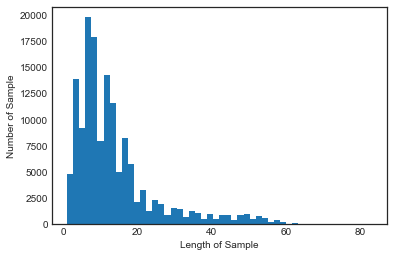

In [17]:
# 시각화
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel("Length of Sample")
plt.ylabel("Number of Sample")
plt.show()

In [18]:
max_len = 60

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [19]:
x_train

array([[    0,     0,     0, ...,    13,    26,   697],
       [    0,     0,     0, ...,     9,    36,   362],
       [    0,     0,     0, ...,    17,   190,     1],
       ...,
       [    0,     0,     0, ..., 11017,  2654,     3],
       [    0,     0,     0, ...,    52,   366,  8187],
       [    0,     0,     0, ...,    78,  2611,     2]])

모델 구성

In [20]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2162800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,280,177
Trainable params: 2,280,177
Non-trainable params: 0
_________________________________________________________________


In [22]:
print(y_train.shape, y_test.shape)
print(x_train.shape, x_test.shape)

(145380,) (48995,)
(145380, 60) (48995, 60)


In [23]:
history = model.fit(x_train, y_train, epochs=15, batch_size=60,
                    validation_split=0.2)

Epoch 1/15
1939/1939 [==============================] - 19s 8ms/step - loss: 0.3917 - acc: 0.8247 - val_loss: 0.3461 - val_acc: 0.8471
Epoch 2/15
1939/1939 [==============================] - 15s 8ms/step - loss: 0.3196 - acc: 0.8623 - val_loss: 0.3259 - val_acc: 0.8579
Epoch 3/15
1939/1939 [==============================] - 15s 8ms/step - loss: 0.2911 - acc: 0.8771 - val_loss: 0.3176 - val_acc: 0.8644
Epoch 4/15
1939/1939 [==============================] - 16s 8ms/step - loss: 0.2708 - acc: 0.8877 - val_loss: 0.3150 - val_acc: 0.8680
Epoch 5/15
1939/1939 [==============================] - 16s 8ms/step - loss: 0.2539 - acc: 0.8961 - val_loss: 0.3154 - val_acc: 0.8660
Epoch 6/15
1939/1939 [==============================] - 16s 8ms/step - loss: 0.2389 - acc: 0.9039 - val_loss: 0.3185 - val_acc: 0.8638
Epoch 7/15
1939/1939 [==============================] - 16s 8ms/step - loss: 0.2245 - acc: 0.9104 - val_loss: 0.3214 - val_acc: 0.8669
Epoch 8/15
1939/1939 [==============================] -

In [25]:
model.evaluate(x_test, y_test)

1532/1532 [==============================] - 6s 4ms/step - loss: 0.4864 - acc: 0.8328


[0.48638397455215454, 0.8327992558479309]

시각화

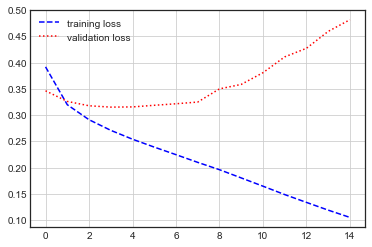

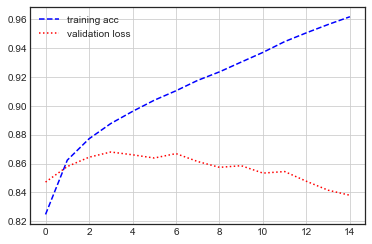

In [26]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label="training loss")
plt.plot(val_loss, 'r:', label="validation loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label="training acc")
plt.plot(val_acc, 'r:', label="validation loss")
plt.legend()
plt.grid()

감정 예측

In [28]:
def sentiment_predict(new_sentence):
    new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score = float(model.predict(new_pad))
    
    if score > 0.5:
        print("{} -> 긍정({:.2f})%".format(new_sentence, score*100))
    else:
        print("{} -> 부정({:.2f})%".format(new_sentence, (1-score)*100))

In [29]:
sentiment_predict("정말 재미있고 흥미진진 했어요.")
sentiment_predict("어떻게 이렇게 지루하고 재미없죠?")
sentiment_predict("배우 연기력이 대박입니다.")
sentiment_predict("분위기가 어둡고 스토리가 복잡해요.")


정말 재미있고 흥미진진 했어요. -> 긍정(99.52)%
어떻게 이렇게 지루하고 재미없죠? -> 부정(99.11)%
배우 연기력이 대박입니다. -> 긍정(69.52)%
분위기가 어둡고 스토리가 복잡해요. -> 긍정(65.43)%
